# Iris Species Classification with Conditional GMM

This example shows how to use conditional GMMs to model the relationship between flower measurements and species.

**What you'll see:**
- Conditional density plots for each iris species
- Data points overlaid on the density contours
- Comparison of different GMM approaches


In [4]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # must be before pyplot import
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from cgmm import ConditionalGMMRegressor, MixtureOfExpertsRegressor, DiscriminativeConditionalGMMRegressor

# Load and prepare iris data
iris = load_iris()
X = iris.data[:, :2]  # Use only first 2 features for visualization
y_labels = iris.target
species_names = iris.target_names

# One-hot encode species labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y_labels.reshape(-1, 1))

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Species: {species_names}")


Dataset: 150 samples, 2 features
Species: ['setosa' 'versicolor' 'virginica']


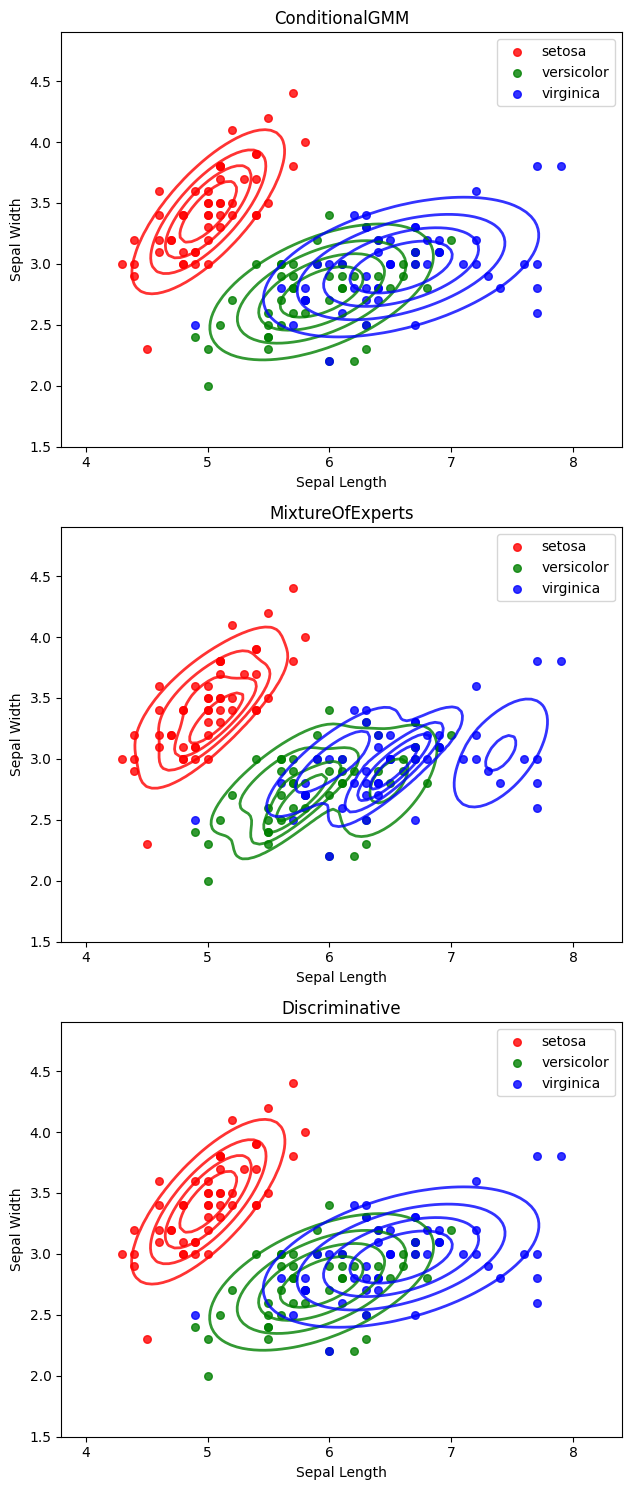

Model Performance:
ConditionalGMM : Log-likelihood = -0.785
MixtureOfExperts: Log-likelihood = -0.719
Discriminative : Log-likelihood = -0.785


In [6]:
import matplotlib.pyplot as plt

# Fit all three models
models = {
    'ConditionalGMM': ConditionalGMMRegressor(n_components=3, random_state=42),
    'MixtureOfExperts': MixtureOfExpertsRegressor(n_components=3, random_state=42),
    'Discriminative': DiscriminativeConditionalGMMRegressor(n_components=3, random_state=42)
}

# Train models and create visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
colors = ['red', 'green', 'blue']

for idx, (name, model) in enumerate(models.items()):
    model.fit(y_onehot, X)
    ax = axes[idx]
    
    # Create grid for density evaluation
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Plot conditional densities for each species
    for species_idx in range(3):
        # Create batch of species labels for all grid points
        species_onehot_batch = np.zeros((grid_points.shape[0], 3))
        species_onehot_batch[:, species_idx] = 1.0
        
        # Calculate density for all grid points at once using log_prob
        log_density = model.log_prob(species_onehot_batch, grid_points)
        density = np.exp(log_density)
        density = density.reshape(xx.shape)
        
        # Normalize density for better visualization
        density = density / density.max()
        
        # Plot contour with same color as data points
        ax.contour(xx, yy, density, levels=5, alpha=0.8, colors=[colors[species_idx]], linewidths=2)
        
        # Plot data points for this species
        species_mask = y_labels == species_idx
        ax.scatter(X[species_mask, 0], X[species_mask, 1], 
                  c=colors[species_idx], s=30, alpha=0.8, 
                  label=species_names[species_idx])
    
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')
    ax.set_title(f'{name}')
    ax.legend()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Show performance metrics
print("Model Performance:")
print("=" * 40)
for name, model in models.items():
    score = model.score(y_onehot, X)
    print(f"{name:15}: Log-likelihood = {score:.3f}")
